# How often do Afterpay transactions attract late fees?
> Let's take a high level view of how often Afterpay customers pay late, based on Afterpay's FY2019 Annual report.

- toc: true 
- badges: true
- comments: true
- categories: [Bayesian,Finance]
    
- image: images/20-08-21-Afterpay-Customer-Defaults-Part-1/header.jpg

## Introduction

I'm interested in what a typical default with *Afterpay* looks like. I have probably read hundreds of pages of information published by *Afterpay*, but I'm yet to see them mention the average default size.

Because I'm curious, and I'm looking for a way to entertain myself on a long train ride, I decided to try and work it out myself.



> Important:  Obviously I need a disclaimer. If you use anything I say as the basis for any decision, financial or otherwise, you are an idiot.


## What do we know?
* Late Fees Revenue : 46.1 million AUD (Page 54 FY2019 Annual report)
* Average Transaction Value : Approximately 150 AUD (Page 25 FY2019 Annual report)
   
Furthermore, we know that the lowest and highest fee that you can be charged for a single transaction is 10 AUD and 68 AUD. Hence, this in turn bounds the average of the late fees.


![Page 43 of the Afterpay FY2019 Annual Report](../images/20-08-21-Afterpay-Customer-Defaults-Part-1/Page43.png)


Let's spend a minute thinking about the different paths a transaction could take.

1. The customer makes good on all their payments, on time.

2. The customer makes no payments, including late fees.

3. The customer is continually late making payment, but in the end makes all the payments required.

4. A combination of 2 and 3, where the customer makes some payments, before ultimately defaulting.


In the case of 2 and 4, there will be a contribution to *GROSS LOSS* (Afterpay doesn't get paid what's owed in full).

In the case of 3 and 4, there will be a contribution to *LATE FEES* (Afterpay doesn't get paid on time).


Let's now use PyMC3 to performa a *Monte Carlo* simulation, to estimate how often cases 3 and 4 occour. 

In [1]:
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import scipy

plt.rcParams["figure.figsize"] = (10,10)
from warnings import filterwarnings
filterwarnings('ignore')


While not strictly necessary, I'm modelling "underlying_sales_aud", "late_fees_rev_aud" and "average_transaction_value_aud" as random variables, so that they show up in the variable graph.

I'm also going to model *average_transaction_value_aud*, assuming that they have rounded to the nearest 10 AUD.

In [2]:
with pm.Model() as model:
    underlying_sales_aud = pm.Uniform('underlying_sales_aud', lower=5.24715*10**9, upper=5.247249*10**9)
    
    late_fees_rev_aud = pm.Uniform('late_fees_rev', lower=46.05 * 10**6, upper=46.149 * 10**6)
    
    average_transaction_value_aud = pm.Uniform('average_transaction_value', lower=144.50, upper=154.49)
    
    average_late_fee_aud = pm.Uniform('average_late_fee',lower = 10, upper = 68)
    
    number_of_transactions = pm.Deterministic('number_of_transactions', underlying_sales_aud / average_transaction_value_aud)
    
    late_payment_rate = pm.Deterministic('late_payment_rate',late_fees_rev_aud / (number_of_transactions * average_late_fee_aud))
    

Now that we have instantiated all of the random variables, we will take 50,000 draws from them, in order to perform our *Monte carlo* simulation.

In [3]:
with model:
    prior_checks = pm.sample_prior_predictive(samples=50_000, random_seed=0)

## Variable Graph

We can graph the relationship between all our variables. From this we can quickly see which variables are key dependencies. 

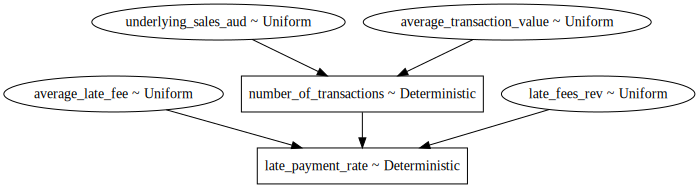

In [4]:
pm.model_to_graphviz(model)

## Results

We can now visualise the distribution of possible values for the late payment rate. 

AttributeError: module 'matplotlib.pyplot' has no attribute 'ylable'

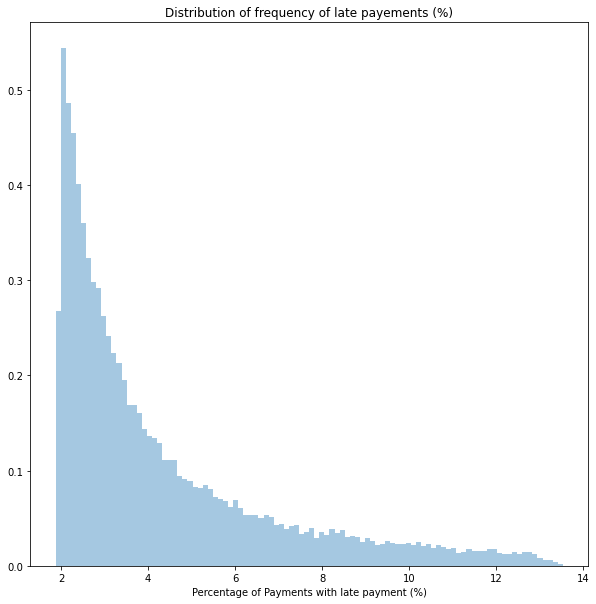

In [8]:
sns.distplot(100*prior_checks["late_payment_rate"], kde=False, norm_hist=True, bins=100)
plt.title('Distribution of frequency of late payements (%)')
plt.xlabel('Percentage of Payments with late payment (%)')
plt.ylable('Relative Frequency')
plt.show()

From this chart, we can see that there is a high *likelyhood* that the value of this parameter is between 2 and 14%.

Infact, we can find there is a 94% chance it's between 1.9%	and 9.8% using PyMC3's summary function.

In [6]:
pm.summary(prior_checks['late_payment_rate'])

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.043,0.025,0.019,0.097,0.0,0.0,48586.0,47975.0,49350.0,46251.0,NaN


## Conclusion
Based on the assumptions we made, we can get a high level understanding of how common it is for *Afterpay* customers to be late in payment. Based on our model, and assumptions, it's approximately 4.3% of the time.

We made a number of implicit assumptions:
 * All payments are the same size.
 * The average late fee is uniformly distributed between 10 AUD and 68 AUD.

In future posts, I want to further refine the model, to build a more accurate distribution, and narrow down it's bounds.
